# Spatial Transcriptomics Analysis: H. pylori-Associated Gastric Cancer CAF Analysis

**Dataset**: GSE308624 - CosMx Spatial Molecular Imager data from 71 gastric cancer patients

**Reference**: Chen et al. (2025) Molecular Cancer 24:282


## 1. Setup and Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors

# Set plotting parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(8, 6))
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("Libraries loaded successfully!")
print(f"Scanpy version: {sc.__version__}")
print(f"Squidpy version: {sq.__version__}")

Libraries loaded successfully!
Scanpy version: 1.11.5
Squidpy version: 1.7.0


In [2]:
# Load the data files
data_path = './Data/GEO/'

# Try loading the processed file first
print("Loading processed data...")
adata = sc.read_h5ad(data_path + 'GSE308624_gastric_cancer_smi_processed.h5ad')

print(f"\nData loaded successfully!")
print(f"Shape: {adata.shape} (cells x genes)")
print(f"\nAvailable observations (obs): {list(adata.obs.columns)}")
print(f"\nAvailable variables (var): {list(adata.var.columns)}")
print(f"\nAvailable obsm (embeddings/coordinates): {list(adata.obsm.keys())}")
print(f"\nAvailable uns (unstructured): {list(adata.uns.keys())}")

Loading processed data...

Data loaded successfully!
Shape: (200182, 1000) (cells x genes)

Available observations (obs): ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18', 'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'cell_ID', 'x_FOV_px', 'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'cell_type', 'sample']

Available variables (var): ['backgroundTestpVals', 'qcFlagsBackground', 'qcFlagsQuantileSummary', 'RNA_spatialDE_8b67301b.0967.4a4d.83d6.15192d1acda3_1_Moran_I', 'RNA_spatialDE_8b67301b.0967.4a4d.83d6.15192d1acda3_1_Moran_pval', 'RNA_spatialDE_8b67301b.0967.4a4d.83d6.15192d1acda3_1_Moran_padj', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variab

In [3]:
# 1. What cell types are available?
print("Cell types:", adata.obs['cell_type'].value_counts())
print(f"\nNumber of unique cell types: {adata.obs['cell_type'].nunique()}")

# 2. How many samples and their distribution?
print("\nSample distribution:")
print(adata.obs['sample'].value_counts().head(10))
print(f"Total unique samples: {adata.obs['sample'].nunique()}")

# 3. Check for H. pylori status or other clinical metadata
print("\nAvailable metadata columns:")
print(adata.obs.columns.tolist())

# 4. Check if CAF subtypes are already annotated
caf_related = adata.obs['cell_type'].unique()
print("\nCell types (full list):")
for ct in sorted(caf_related):
    print(f"  - {ct}")

# 5. Check for key marker genes (CAF and immune)
marker_genes = ['THBS1', 'ZFP36', 'FN1', 'ACTA2', 'POSTN', 'CXCL12', 
                'CD3D', 'CD8A', 'FOXP3', 'EPCAM', 'PDGFRA']
available_markers = [g for g in marker_genes if g in adata.var_names]
print(f"\nKey marker genes available: {available_markers}")

# 6. Spatial extent check (one sample)
sample_1 = adata[adata.obs['sample'] == adata.obs['sample'].unique()[0]]
print(f"\nExample sample: {sample_1.obs['sample'].iloc[0]}")
print(f"  Cells: {sample_1.n_obs}")
print(f"  Spatial range X: {sample_1.obsm['spatial'][:, 0].min():.2f} to {sample_1.obsm['spatial'][:, 0].max():.2f}")
print(f"  Spatial range Y: {sample_1.obsm['spatial'][:, 1].min():.2f} to {sample_1.obsm['spatial'][:, 1].max():.2f}")

Cell types: cell_type
Cancer_cell    97689
Fibroblast     34686
B_cell         26144
T_cell         15958
Mocrophage     12697
Endothelial     7766
SMC             4710
DC               532
Name: count, dtype: int64

Number of unique cell types: 8

Sample distribution:
sample
62.0     7083
55.0     6677
23.0     6309
25.0     6174
44.0     6058
63.0     5808
85.0     5664
102.0    5436
83.0     5408
15.0     5328
Name: count, dtype: int64
Total unique samples: 71

Available metadata columns:
['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18', 'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'cell_ID', 'x_FOV_px', 'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'cell_type', 'sample']

Cell types (full list):
  

In [4]:
# Explore existing cell type annotations
print("=" * 80)
print("CELL TYPE INFORMATION")
print("=" * 80)

if 'cell_type' in adata.obs.columns:
    print(f"\nCell types found: {adata.obs['cell_type'].nunique()}")
    print("\nCell type distribution:")
    print(adata.obs['cell_type'].value_counts())
    
    # Check for CAF-related cell types
    caf_types = adata.obs[adata.obs['cell_type'].str.contains('CAF|Fibroblast|fibroblast', case=False, na=False)]['cell_type'].unique()
    if len(caf_types) > 0:
        print(f"\nCAF/Fibroblast cell types found: {list(caf_types)}")

# Check sample information
print("\n" + "=" * 80)
print("SAMPLE INFORMATION")
print("=" * 80)

if 'sample' in adata.obs.columns:
    print(f"\nNumber of samples: {adata.obs['sample'].nunique()}")
    print(f"\nSample distribution (top 10):")
    print(adata.obs['sample'].value_counts().head(10))
    
# Check for H. pylori or condition information
condition_cols = [col for col in adata.obs.columns if any(x in col.lower() for x in ['condition', 'status', 'group', 'pylori', 'hp'])]
if condition_cols:
    print(f"\nPotential condition columns: {condition_cols}")
    for col in condition_cols[:3]:
        print(f"\n{col}:")
        print(adata.obs[col].value_counts())

CELL TYPE INFORMATION

Cell types found: 8

Cell type distribution:
cell_type
Cancer_cell    97689
Fibroblast     34686
B_cell         26144
T_cell         15958
Mocrophage     12697
Endothelial     7766
SMC             4710
DC               532
Name: count, dtype: int64

CAF/Fibroblast cell types found: ['Fibroblast']

SAMPLE INFORMATION

Number of samples: 71

Sample distribution (top 10):
sample
62.0     7083
55.0     6677
23.0     6309
25.0     6174
44.0     6058
63.0     5808
85.0     5664
102.0    5436
83.0     5408
15.0     5328
Name: count, dtype: int64


In [5]:
# Check for key marker genes
print("=" * 80)
print("MARKER GENE AVAILABILITY")
print("=" * 80)

# Define marker genes from the paper
marker_genes = {
    'CAF_general': ['ACTA2', 'FAP', 'PDGFRA', 'COL1A1'],
    'proCAF': ['IGF1', 'SFRP1', 'SFRP2'],
    'iCAF': ['CXCL12', 'CXCL14'],
    'matCAF': ['POSTN', 'COL11A1'],
    'myCAF': ['ACTA2', 'RGS5', 'TAGLN'],
    'Key_genes': ['THBS1', 'ZFP36'],
    'Cancer': ['EPCAM', 'KRT8', 'KRT18'],
    'T_cells': ['CD3D', 'CD3E', 'CD8A', 'FOXP3'],
    'B_cells': ['CD79A', 'MS4A1'],
    'Myeloid': ['CD68', 'CD14']
}

# Check which genes are present
gene_names = adata.var_names.tolist()

for category, genes in marker_genes.items():
    print(f"\n{category}:")
    for gene in genes:
        if gene in gene_names:
            print(f"  ✓ {gene}")
        else:
            print(f"  ✗ {gene} (not found)")

MARKER GENE AVAILABILITY

CAF_general:
  ✓ ACTA2
  ✓ FAP
  ✓ PDGFRA
  ✓ COL1A1

proCAF:
  ✓ IGF1
  ✗ SFRP1 (not found)
  ✗ SFRP2 (not found)

iCAF:
  ✓ CXCL12
  ✓ CXCL14

matCAF:
  ✗ POSTN (not found)
  ✓ COL11A1

myCAF:
  ✓ ACTA2
  ✓ RGS5
  ✓ TAGLN

Key_genes:
  ✓ THBS1
  ✓ ZFP36

Cancer:
  ✓ EPCAM
  ✓ KRT8
  ✓ KRT18

T_cells:
  ✓ CD3D
  ✓ CD3E
  ✓ CD8A
  ✓ FOXP3

B_cells:
  ✓ CD79A
  ✓ MS4A1

Myeloid:
  ✓ CD68
  ✓ CD14


## 2. Data Quality Control

QUALITY CONTROL METRICS

QC Metrics Summary:
       n_genes_by_counts  log1p_n_genes_by_counts   total_counts  \
count      200182.000000            200182.000000  200182.000000   
mean           79.927616                 4.302386      28.178636   
std            35.479120                 0.425946       2.218112   
min            21.000000                 3.091042      15.226288   
25%            52.000000                 3.970292      26.757464   
50%            71.000000                 4.276666      28.403338   
75%           102.000000                 4.634729      29.895516   
max           257.000000                 5.552960      33.496369   

       log1p_total_counts  
count       200182.000000  
mean             3.370400  
std              0.078997  
min              2.786633  
25%              3.323505  
50%              3.381108  
75%              3.430611  
max              3.540854  


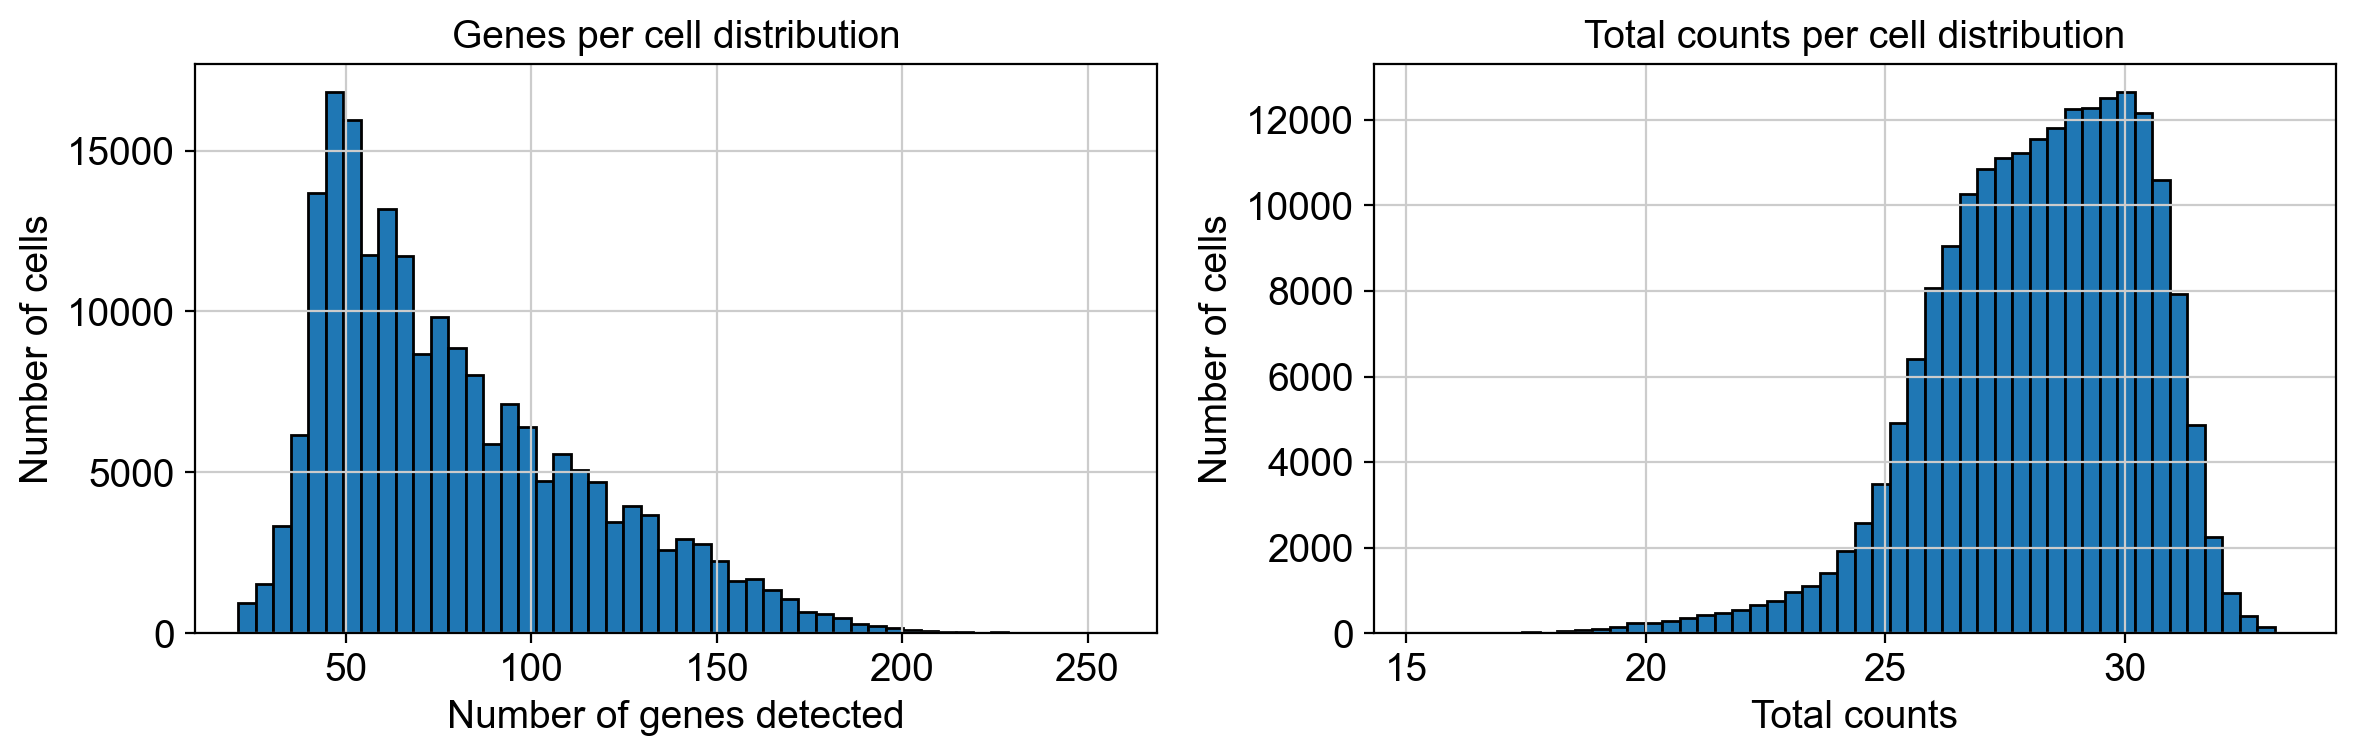

In [6]:
# Basic QC metrics
print("=" * 80)
print("QUALITY CONTROL METRICS")
print("=" * 80)

# Calculate QC metrics if not already present
if 'n_genes' not in adata.obs.columns:
    sc.pp.calculate_qc_metrics(adata, inplace=True)

# Display QC statistics
qc_cols = [col for col in adata.obs.columns if any(x in col for x in ['n_genes', 'n_counts', 'total_counts'])]
if qc_cols:
    print("\nQC Metrics Summary:")
    print(adata.obs[qc_cols].describe())

# Visualize QC metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if 'n_genes_by_counts' in adata.obs.columns:
    axes[0].hist(adata.obs['n_genes_by_counts'], bins=50, edgecolor='black')
    axes[0].set_xlabel('Number of genes detected')
    axes[0].set_ylabel('Number of cells')
    axes[0].set_title('Genes per cell distribution')

if 'total_counts' in adata.obs.columns:
    axes[1].hist(adata.obs['total_counts'], bins=50, edgecolor='black')
    axes[1].set_xlabel('Total counts')
    axes[1].set_ylabel('Number of cells')
    axes[1].set_title('Total counts per cell distribution')

plt.tight_layout()
plt.savefig('figures/qc_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


Number of samples: 71

Cells per sample:
count      71.000000
mean     2819.464789
std      1735.547240
min       101.000000
25%      1352.500000
50%      2762.000000
75%      3742.000000
max      7083.000000
Name: count, dtype: float64


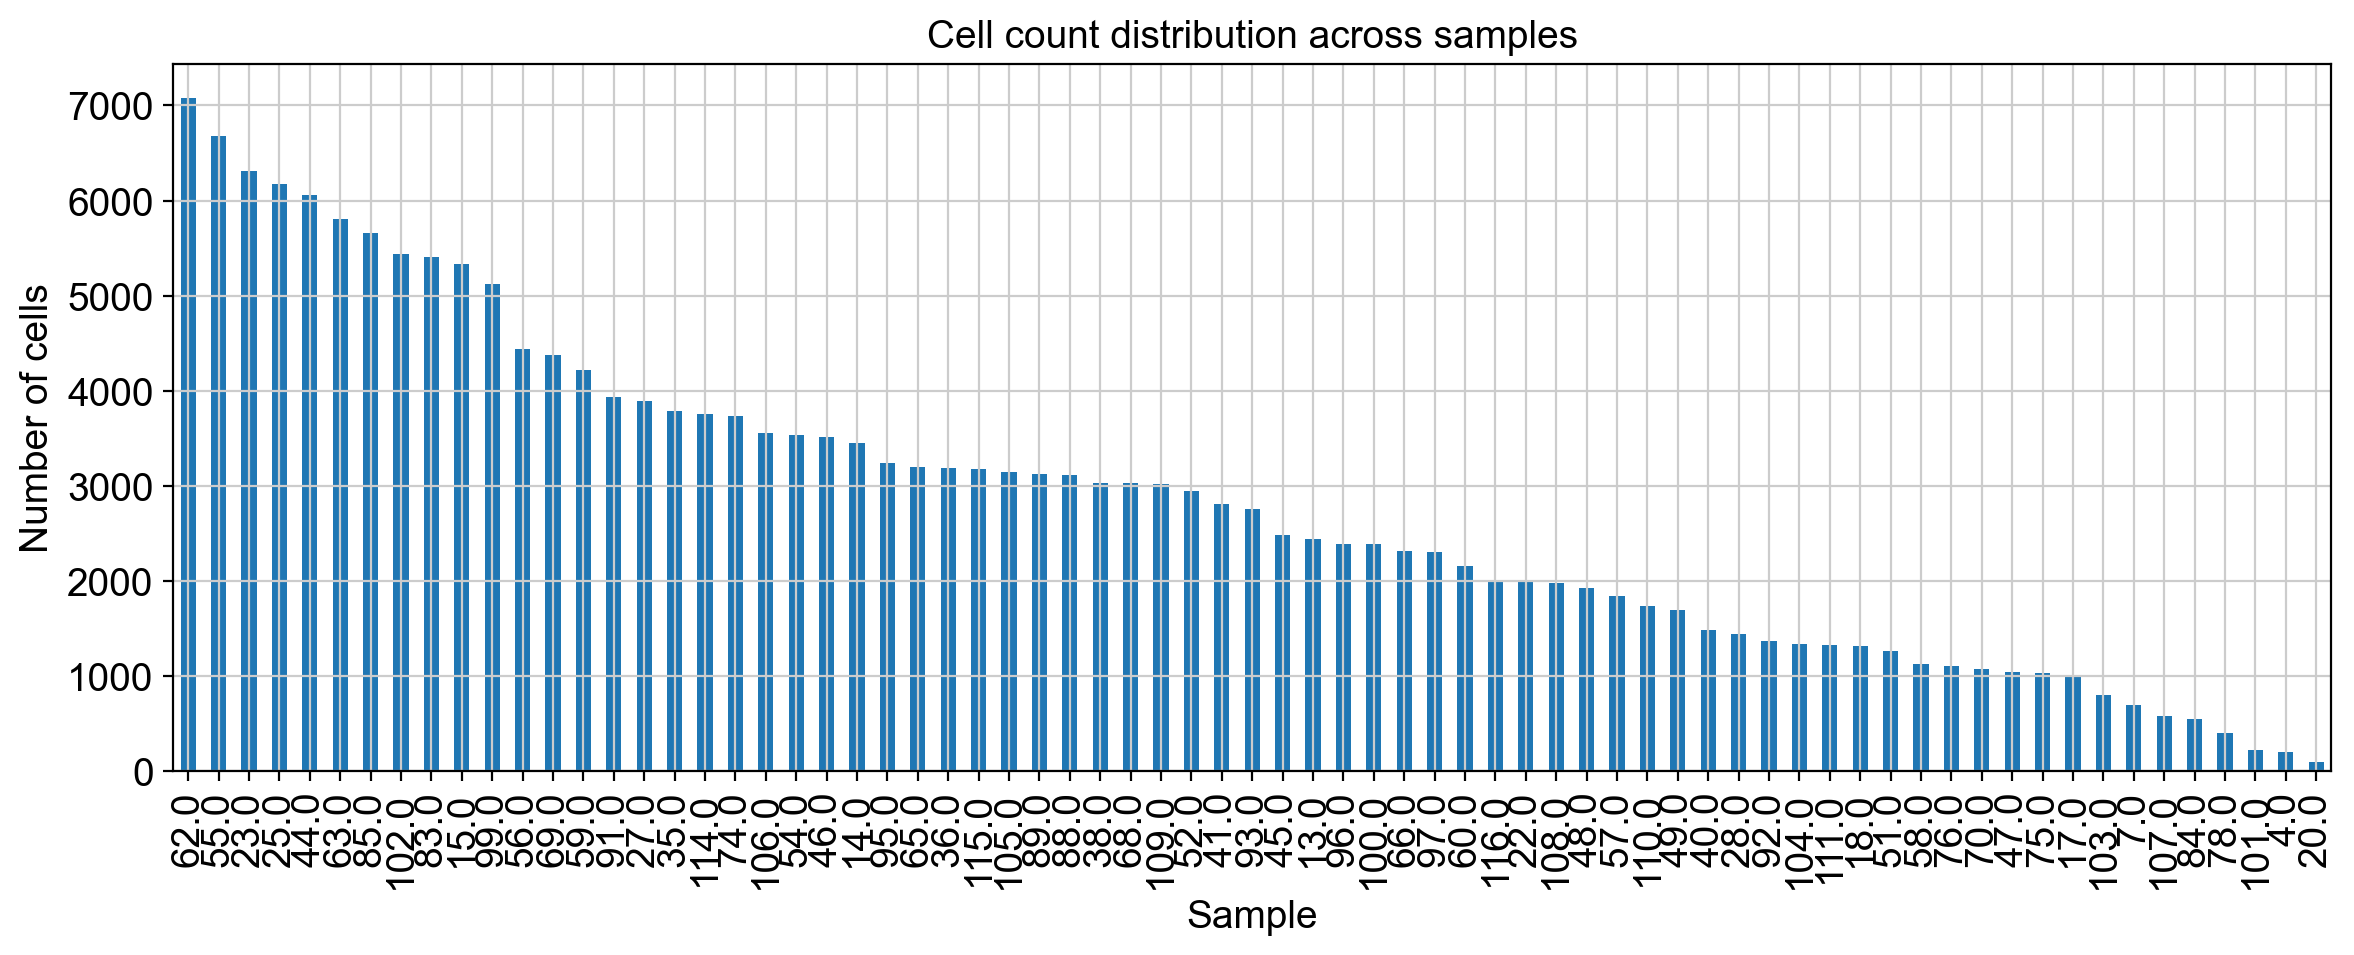

In [7]:
# Check sample distribution
if 'sample' in adata.obs.columns or 'Sample' in adata.obs.columns:
    sample_col = 'sample' if 'sample' in adata.obs.columns else 'Sample'
    
    print(f"\nNumber of samples: {adata.obs[sample_col].nunique()}")
    print(f"\nCells per sample:")
    sample_counts = adata.obs[sample_col].value_counts().sort_values(ascending=False)
    print(sample_counts.describe())
    
    # Plot cells per sample
    fig, ax = plt.subplots(figsize=(12, 5))
    sample_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Number of cells')
    ax.set_title('Cell count distribution across samples')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('figures/cells_per_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

## 3. Cell Type Annotation and CAF Subtyping

In [8]:
# Score cells based on marker gene expression
# This will be useful even with existing annotations to understand marker expression patterns

def score_cell_type(adata, markers, score_name):
    """
    Score cells based on marker gene expression.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    markers : list
        List of marker genes
    score_name : str
        Name for the score column
    """
    # Filter for genes that exist
    available_markers = [g for g in markers if g in adata.var_names]
    
    if len(available_markers) == 0:
        print(f"  ⚠ Warning: No markers found for {score_name}")
        return
    
    # Use scanpy's score_genes function
    sc.tl.score_genes(adata, available_markers, score_name=score_name)
    print(f"  ✓ Scored {score_name} using {len(available_markers)}/{len(markers)} genes")

print("=" * 80)
print("MARKER GENE SCORING")
print("=" * 80)

# Score CAF subtypes based on literature markers
print("\nScoring CAF subtypes based on marker genes...")
score_cell_type(adata, marker_genes['proCAF'], 'proCAF_score')
score_cell_type(adata, marker_genes['iCAF'], 'iCAF_score')
score_cell_type(adata, marker_genes['matCAF'], 'matCAF_score')
score_cell_type(adata, marker_genes['myCAF'], 'myCAF_score')

# Score other cell types for comparison
print("\nScoring other major cell types...")
score_cell_type(adata, marker_genes['Cancer'], 'Cancer_score')
score_cell_type(adata, marker_genes['T_cells'], 'T_cell_score')
score_cell_type(adata, marker_genes['B_cells'], 'B_cell_score')
score_cell_type(adata, marker_genes['Myeloid'], 'Myeloid_score')

print("\n✓ Marker scoring complete")

MARKER GENE SCORING

Scoring CAF subtypes based on marker genes...
computing score 'proCAF_score'
    finished: added
    'proCAF_score', score of gene set (adata.obs).
    41 total control genes are used. (0:00:00)
  ✓ Scored proCAF_score using 1/3 genes
computing score 'iCAF_score'
    finished: added
    'iCAF_score', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
  ✓ Scored iCAF_score using 2/2 genes
computing score 'matCAF_score'
    finished: added
    'matCAF_score', score of gene set (adata.obs).
    41 total control genes are used. (0:00:00)
  ✓ Scored matCAF_score using 1/2 genes
computing score 'myCAF_score'
    finished: added
    'myCAF_score', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
  ✓ Scored myCAF_score using 3/3 genes

Scoring other major cell types...
computing score 'Cancer_score'
    finished: added
    'Cancer_score', score of gene set (adata.obs).
    74 total control genes are used. (0:00:00)
 

In [9]:
# Identify CAF cells - use existing annotations if available, otherwise use scores
print("=" * 80)
print("CAF IDENTIFICATION")
print("=" * 80)

# Check if we have existing CAF annotations
has_caf_annotations = False
if 'cell_type' in adata.obs.columns:
    caf_mask = adata.obs['cell_type'].str.contains('CAF|Fibroblast|fibroblast', case=False, na=False)
    if caf_mask.sum() > 0:
        has_caf_annotations = True
        adata.obs['is_CAF'] = caf_mask
        # Copy cell_type info to CAF_subtype for consistency
        adata.obs['CAF_subtype'] = 'Non-CAF'
        adata.obs.loc[caf_mask, 'CAF_subtype'] = adata.obs.loc[caf_mask, 'cell_type']
        
        print(f"✓ Using existing CAF annotations from 'cell_type' column")
        print(f"\nCAF cell types found:")
        print(adata.obs[caf_mask]['cell_type'].value_counts())
        print(f"\nTotal CAF cells: {caf_mask.sum():,} ({100*caf_mask.sum()/len(adata):.2f}%)")

# If no existing annotations, use marker scores
if not has_caf_annotations:
    print("→ No existing CAF annotations found, using marker-based scoring\n")
    
    caf_score_cols = ['proCAF_score', 'iCAF_score', 'matCAF_score', 'myCAF_score']
    available_caf_scores = [col for col in caf_score_cols if col in adata.obs.columns]
    
    if available_caf_scores:
        # Identify cells with high CAF scores
        caf_threshold = 0.2  # Adjust based on score distribution
        
        # Get max CAF score
        adata.obs['max_CAF_score'] = adata.obs[available_caf_scores].max(axis=1)
        adata.obs['is_CAF'] = adata.obs['max_CAF_score'] > caf_threshold
        
        # Assign CAF subtype
        adata.obs['CAF_subtype'] = 'Non-CAF'
        for idx, row in adata.obs[adata.obs['is_CAF']].iterrows():
            max_score_col = row[available_caf_scores].idxmax()
            adata.obs.loc[idx, 'CAF_subtype'] = max_score_col.replace('_score', '')
        
        print("CAF subtype distribution (from marker scores):")
        print(adata.obs['CAF_subtype'].value_counts())
        print(f"\nTotal CAF cells: {adata.obs['is_CAF'].sum():,} ({100*adata.obs['is_CAF'].sum()/len(adata):.2f}%)")
        print(f"CAF threshold used: {caf_threshold}")
    else:
        print("⚠ No CAF scores available - cannot identify CAF cells")

# Also score marker expression for annotated CAFs for comparison
if has_caf_annotations:
    caf_score_cols = ['proCAF_score', 'iCAF_score', 'matCAF_score', 'myCAF_score']
    available_caf_scores = [col for col in caf_score_cols if col in adata.obs.columns]
    
    if available_caf_scores and adata.obs['is_CAF'].sum() > 0:
        print("\n" + "-" * 80)
        print("Comparing existing annotations with marker scores...")
        
        # Get max score for CAF cells
        caf_cells = adata.obs[adata.obs['is_CAF']].copy()
        caf_cells['max_CAF_score'] = caf_cells[available_caf_scores].max(axis=1)
        caf_cells['predicted_subtype'] = caf_cells[available_caf_scores].idxmax(axis=1).str.replace('_score', '')
        
        print(f"\nMarker score distribution for annotated CAF cells:")
        print(caf_cells['max_CAF_score'].describe())
        print(f"\nPredicted subtypes from markers:")
        print(caf_cells['predicted_subtype'].value_counts())

CAF IDENTIFICATION
✓ Using existing CAF annotations from 'cell_type' column

CAF cell types found:
cell_type
Fibroblast     34686
B_cell             0
Cancer_cell        0
DC                 0
Endothelial        0
Mocrophage         0
SMC                0
T_cell             0
Name: count, dtype: int64

Total CAF cells: 34,686 (17.33%)

--------------------------------------------------------------------------------
Comparing existing annotations with marker scores...

Marker score distribution for annotated CAF cells:
count    34686.000000
mean         0.500895
std          0.768088
min         -0.219512
25%         -0.024390
50%          0.227642
75%          0.886179
max          9.926829
Name: max_CAF_score, dtype: float64

Predicted subtypes from markers:
predicted_subtype
myCAF     10920
proCAF     8805
matCAF     7857
iCAF       7104
Name: count, dtype: int64


In [10]:
# Assign CAF subtype based on highest score
caf_score_cols = ['proCAF_score', 'iCAF_score', 'matCAF_score', 'myCAF_score']
available_caf_scores = [col for col in caf_score_cols if col in adata.obs.columns]

if available_caf_scores:
    # Identify cells with high CAF scores
    caf_threshold = 0.2  # Adjust based on score distribution
    
    # Get max CAF score
    adata.obs['max_CAF_score'] = adata.obs[available_caf_scores].max(axis=1)
    adata.obs['is_CAF'] = adata.obs['max_CAF_score'] > caf_threshold
    
    # Assign CAF subtype
    adata.obs['CAF_subtype'] = 'Non-CAF'
    for idx, row in adata.obs[adata.obs['is_CAF']].iterrows():
        max_score_col = row[available_caf_scores].idxmax()
        adata.obs.loc[idx, 'CAF_subtype'] = max_score_col.replace('_score', '')
    
    print("CAF subtype distribution:")
    print(adata.obs['CAF_subtype'].value_counts())
    print(f"\nTotal CAF cells: {adata.obs['is_CAF'].sum():,} ({100*adata.obs['is_CAF'].sum()/len(adata):.2f}%)")

CAF subtype distribution:
CAF_subtype
Non-CAF    130509
myCAF       28364
iCAF        20353
proCAF      11704
matCAF       9252
Name: count, dtype: int64

Total CAF cells: 69,673 (34.80%)


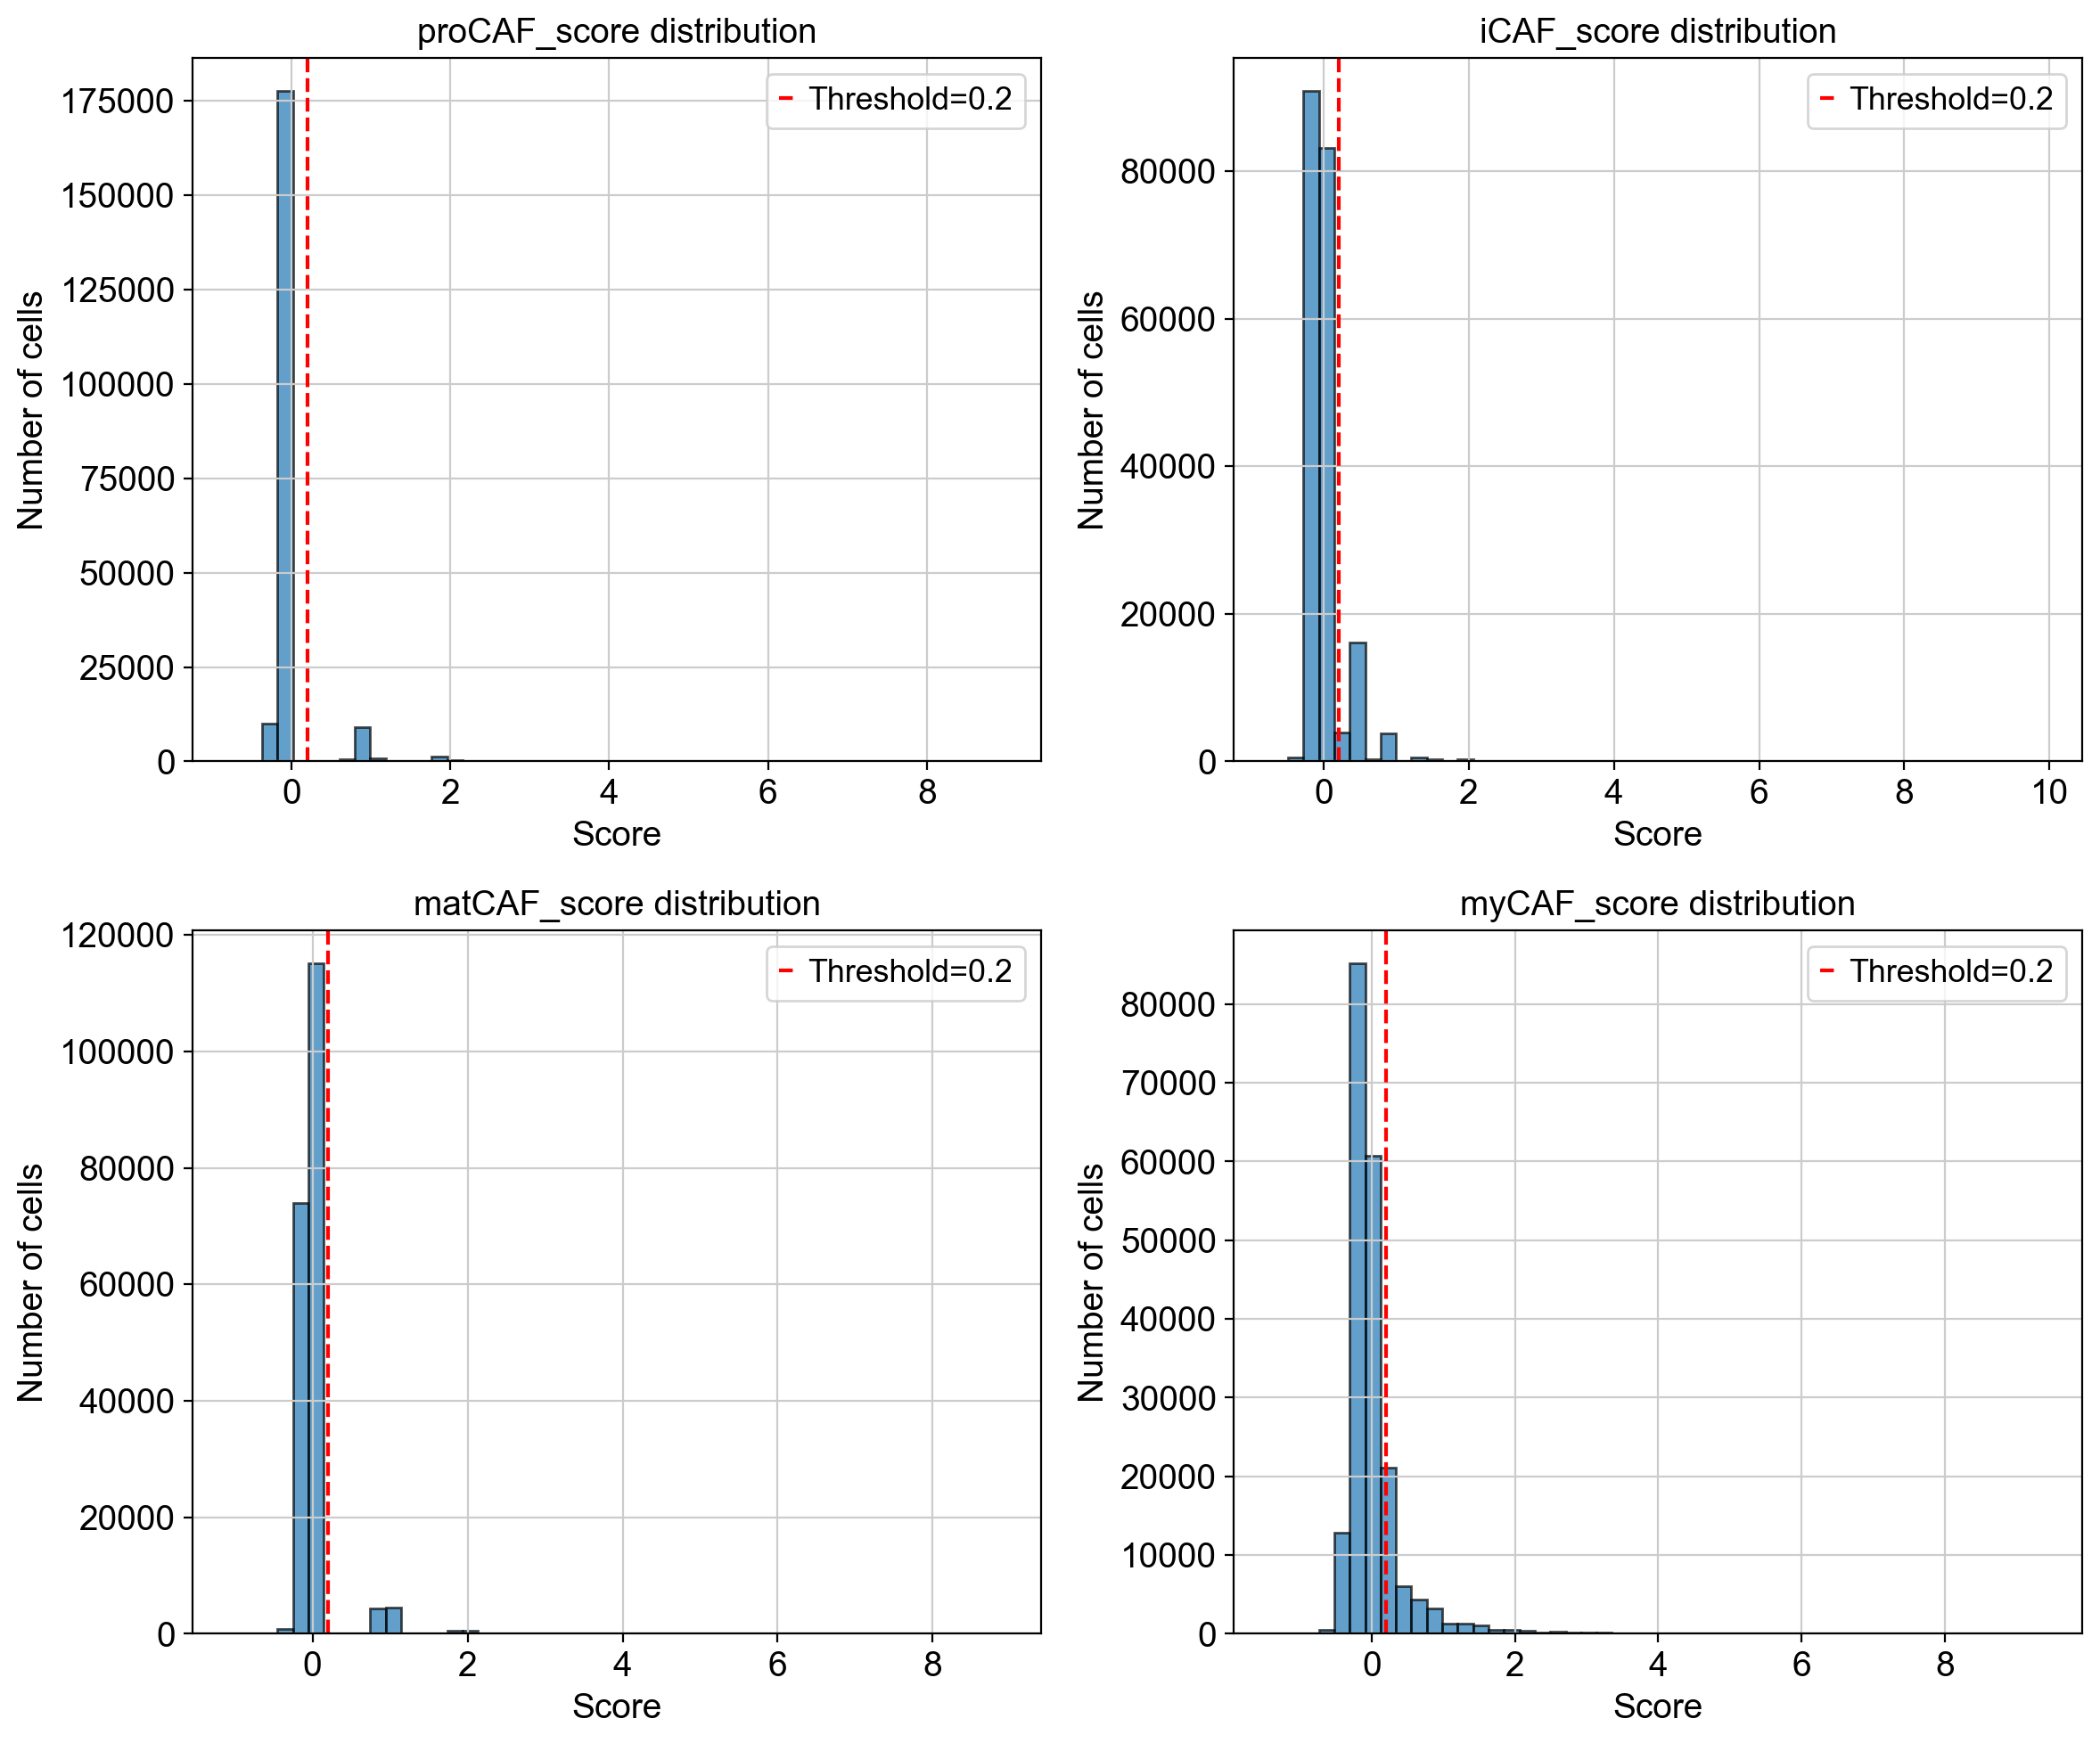

In [11]:
# Visualize CAF score distributions
if available_caf_scores:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, score_col in enumerate(available_caf_scores):
        axes[idx].hist(adata.obs[score_col], bins=50, edgecolor='black', alpha=0.7)
        axes[idx].axvline(caf_threshold, color='red', linestyle='--', label=f'Threshold={caf_threshold}')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Number of cells')
        axes[idx].set_title(f'{score_col} distribution')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig('figures/caf_score_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Spatial Visualization

In [12]:
# Prepare spatial coordinates - use the existing 'spatial' obsm or x_slide_mm/y_slide_mm
print("=" * 80)
print("SPATIAL COORDINATES")
print("=" * 80)

# Check if spatial coordinates exist in obsm
if 'spatial' in adata.obsm.keys():
    print("\n✓ Spatial coordinates found in adata.obsm['spatial']")
    print(f"  Shape: {adata.obsm['spatial'].shape}")
    print(f"  X range: [{adata.obsm['spatial'][:, 0].min():.2f}, {adata.obsm['spatial'][:, 0].max():.2f}] mm")
    print(f"  Y range: [{adata.obsm['spatial'][:, 1].min():.2f}, {adata.obsm['spatial'][:, 1].max():.2f}] mm")
    spatial_key = 'spatial'
else:
    # Use x_slide_mm and y_slide_mm from obs
    print("\n✓ Using x_slide_mm and y_slide_mm from adata.obs")
    adata.obsm['spatial'] = adata.obs[['x_slide_mm', 'y_slide_mm']].values
    print(f"  Shape: {adata.obsm['spatial'].shape}")
    print(f"  X range: [{adata.obsm['spatial'][:, 0].min():.2f}, {adata.obsm['spatial'][:, 0].max():.2f}] mm")
    print(f"  Y range: [{adata.obsm['spatial'][:, 1].min():.2f}, {adata.obsm['spatial'][:, 1].max():.2f}] mm")
    spatial_key = 'spatial'

# Check FOV information
if 'fov' in adata.obs.columns:
    print(f"\n✓ FOV information available")
    print(f"  Number of FOVs: {adata.obs['fov'].nunique()}")
    print(f"  Cells per FOV: {adata.obs.groupby('fov').size().describe()}")

SPATIAL COORDINATES

✓ Spatial coordinates found in adata.obsm['spatial']
  Shape: (200182, 2)
  X range: [0.00, 14.41] mm
  Y range: [-0.47, 18.32] mm

✓ FOV information available
  Number of FOVs: 219
  Cells per FOV: count     219.000000
mean      914.073059
std       488.690906
min       101.000000
25%       581.000000
50%       828.000000
75%      1178.000000
max      2724.000000
dtype: float64


Plotting overall cell type distribution...


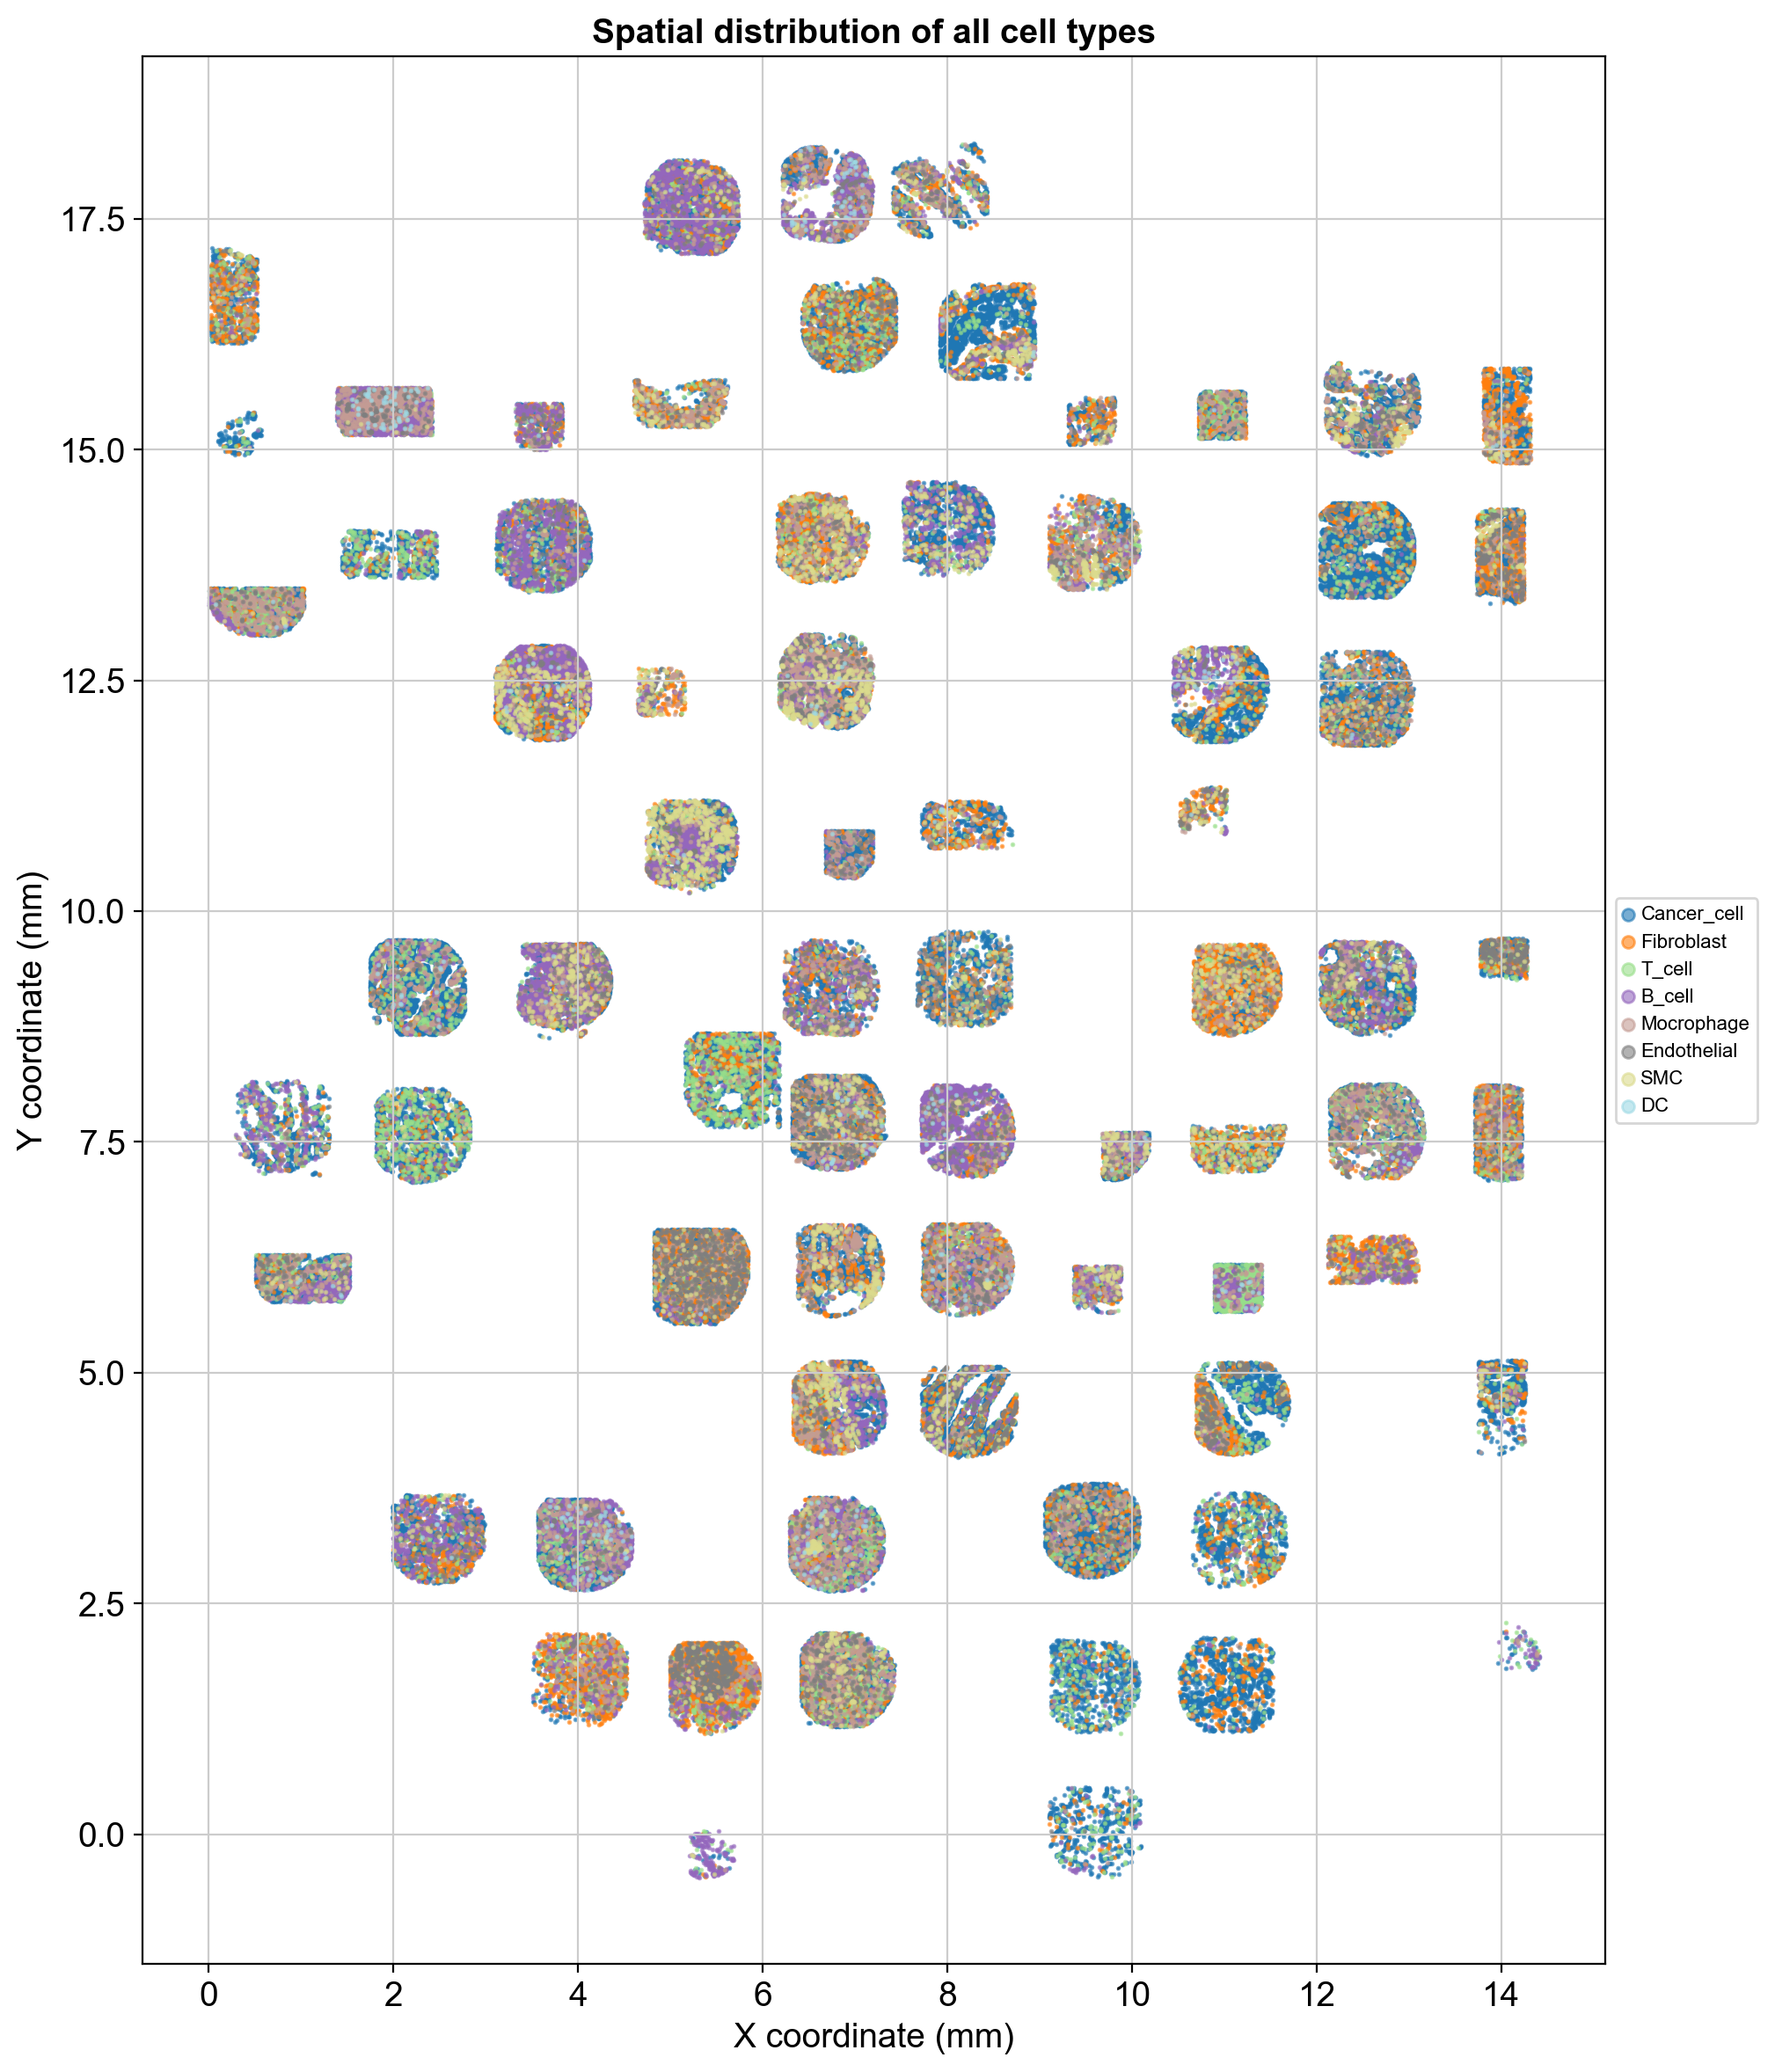

✓ Saved: figures/spatial_all_cell_types.png

Plotting CAF subtypes...


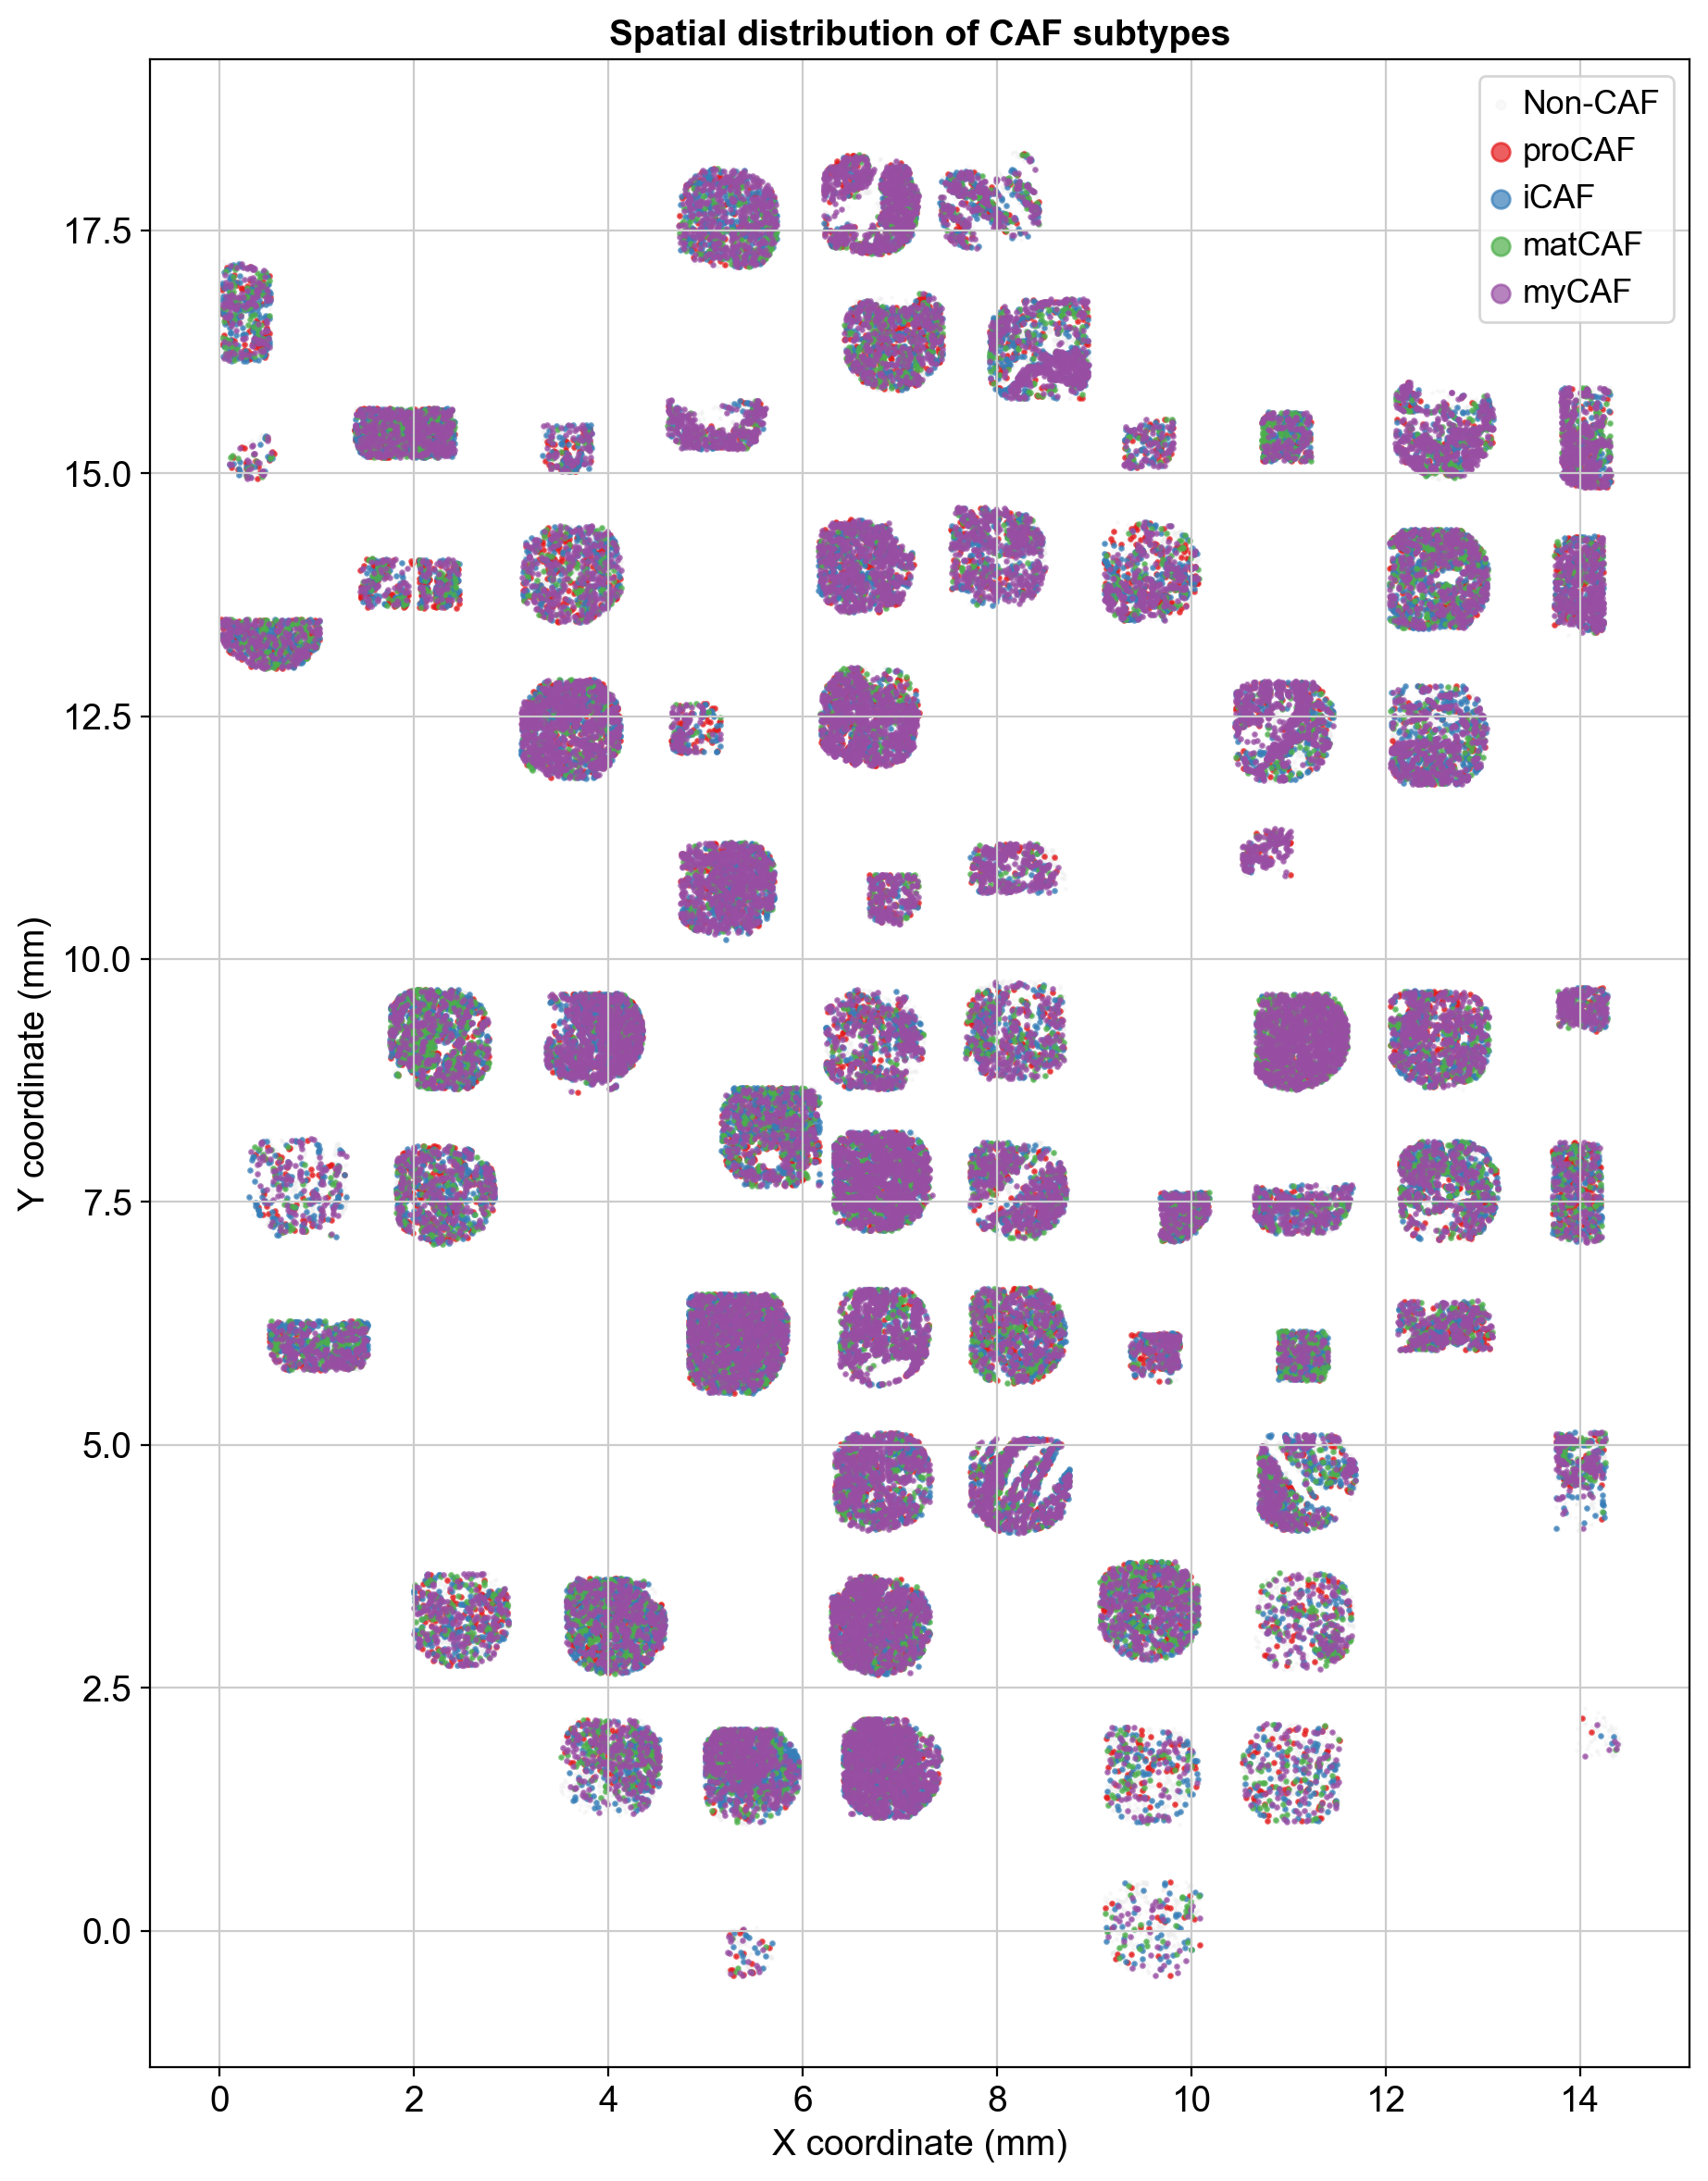

✓ Saved: figures/spatial_caf_subtypes.png


In [27]:
print("Plotting overall cell type distribution...")
fig, ax = plt.subplots(figsize=(14, 12))

cell_types = adata.obs['cell_type'].unique()
n_types = len(cell_types)

# Assign colors
if n_types <= 20:
    colors = plt.cm.tab20(np.linspace(0, 1, n_types))
else:
    colors = plt.cm.hsv(np.linspace(0, 1, n_types))

color_dict = dict(zip(cell_types, colors))

for cell_type, color in color_dict.items():
    mask = adata.obs['cell_type'] == cell_type
    coords = adata.obsm['spatial'][mask]
    ax.scatter(coords[:, 0], coords[:, 1], 
              c=[color], s=1, alpha=0.6, label=cell_type, rasterized=True)

ax.set_xlabel('X coordinate (mm)')
ax.set_ylabel('Y coordinate (mm)')
ax.set_title('Spatial distribution of all cell types', fontsize=14, fontweight='bold')
ax.legend(markerscale=5, frameon=True, loc='center left', bbox_to_anchor=(1, 0.5), 
         fontsize=8, ncol=1)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('figures/spatial_all_cell_types.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/spatial_all_cell_types.png")

# Plot CAF subtypes
print("\nPlotting CAF subtypes...")
fig, ax = plt.subplots(figsize=(14, 12))

# CAF colors
caf_colors = {
    'proCAF': '#E41A1C',
    'iCAF': '#377EB8',
    'matCAF': '#4DAF4A',
    'myCAF': '#984EA3',
    'Non-CAF': '#EEEEEE'
}

# Plot Non-CAF as background
mask = adata.obs['CAF_subtype'] == 'Non-CAF'
coords = adata.obsm['spatial'][mask]
ax.scatter(coords[:, 0], coords[:, 1], 
          c='#EEEEEE', s=0.5, alpha=0.3, label='Non-CAF', rasterized=True)

# Plot CAF subtypes
for subtype in ['proCAF', 'iCAF', 'matCAF', 'myCAF']:
    mask = adata.obs['CAF_subtype'] == subtype
    coords = adata.obsm['spatial'][mask]
    ax.scatter(coords[:, 0], coords[:, 1], 
              c=caf_colors[subtype], s=2, alpha=0.7, 
              label=subtype, rasterized=True)

ax.set_xlabel('X coordinate (mm)')
ax.set_ylabel('Y coordinate (mm)')
ax.set_title('Spatial distribution of CAF subtypes', fontsize=14, fontweight='bold')
ax.legend(markerscale=5, frameon=True, loc='best')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('figures/spatial_caf_subtypes.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/spatial_caf_subtypes.png")

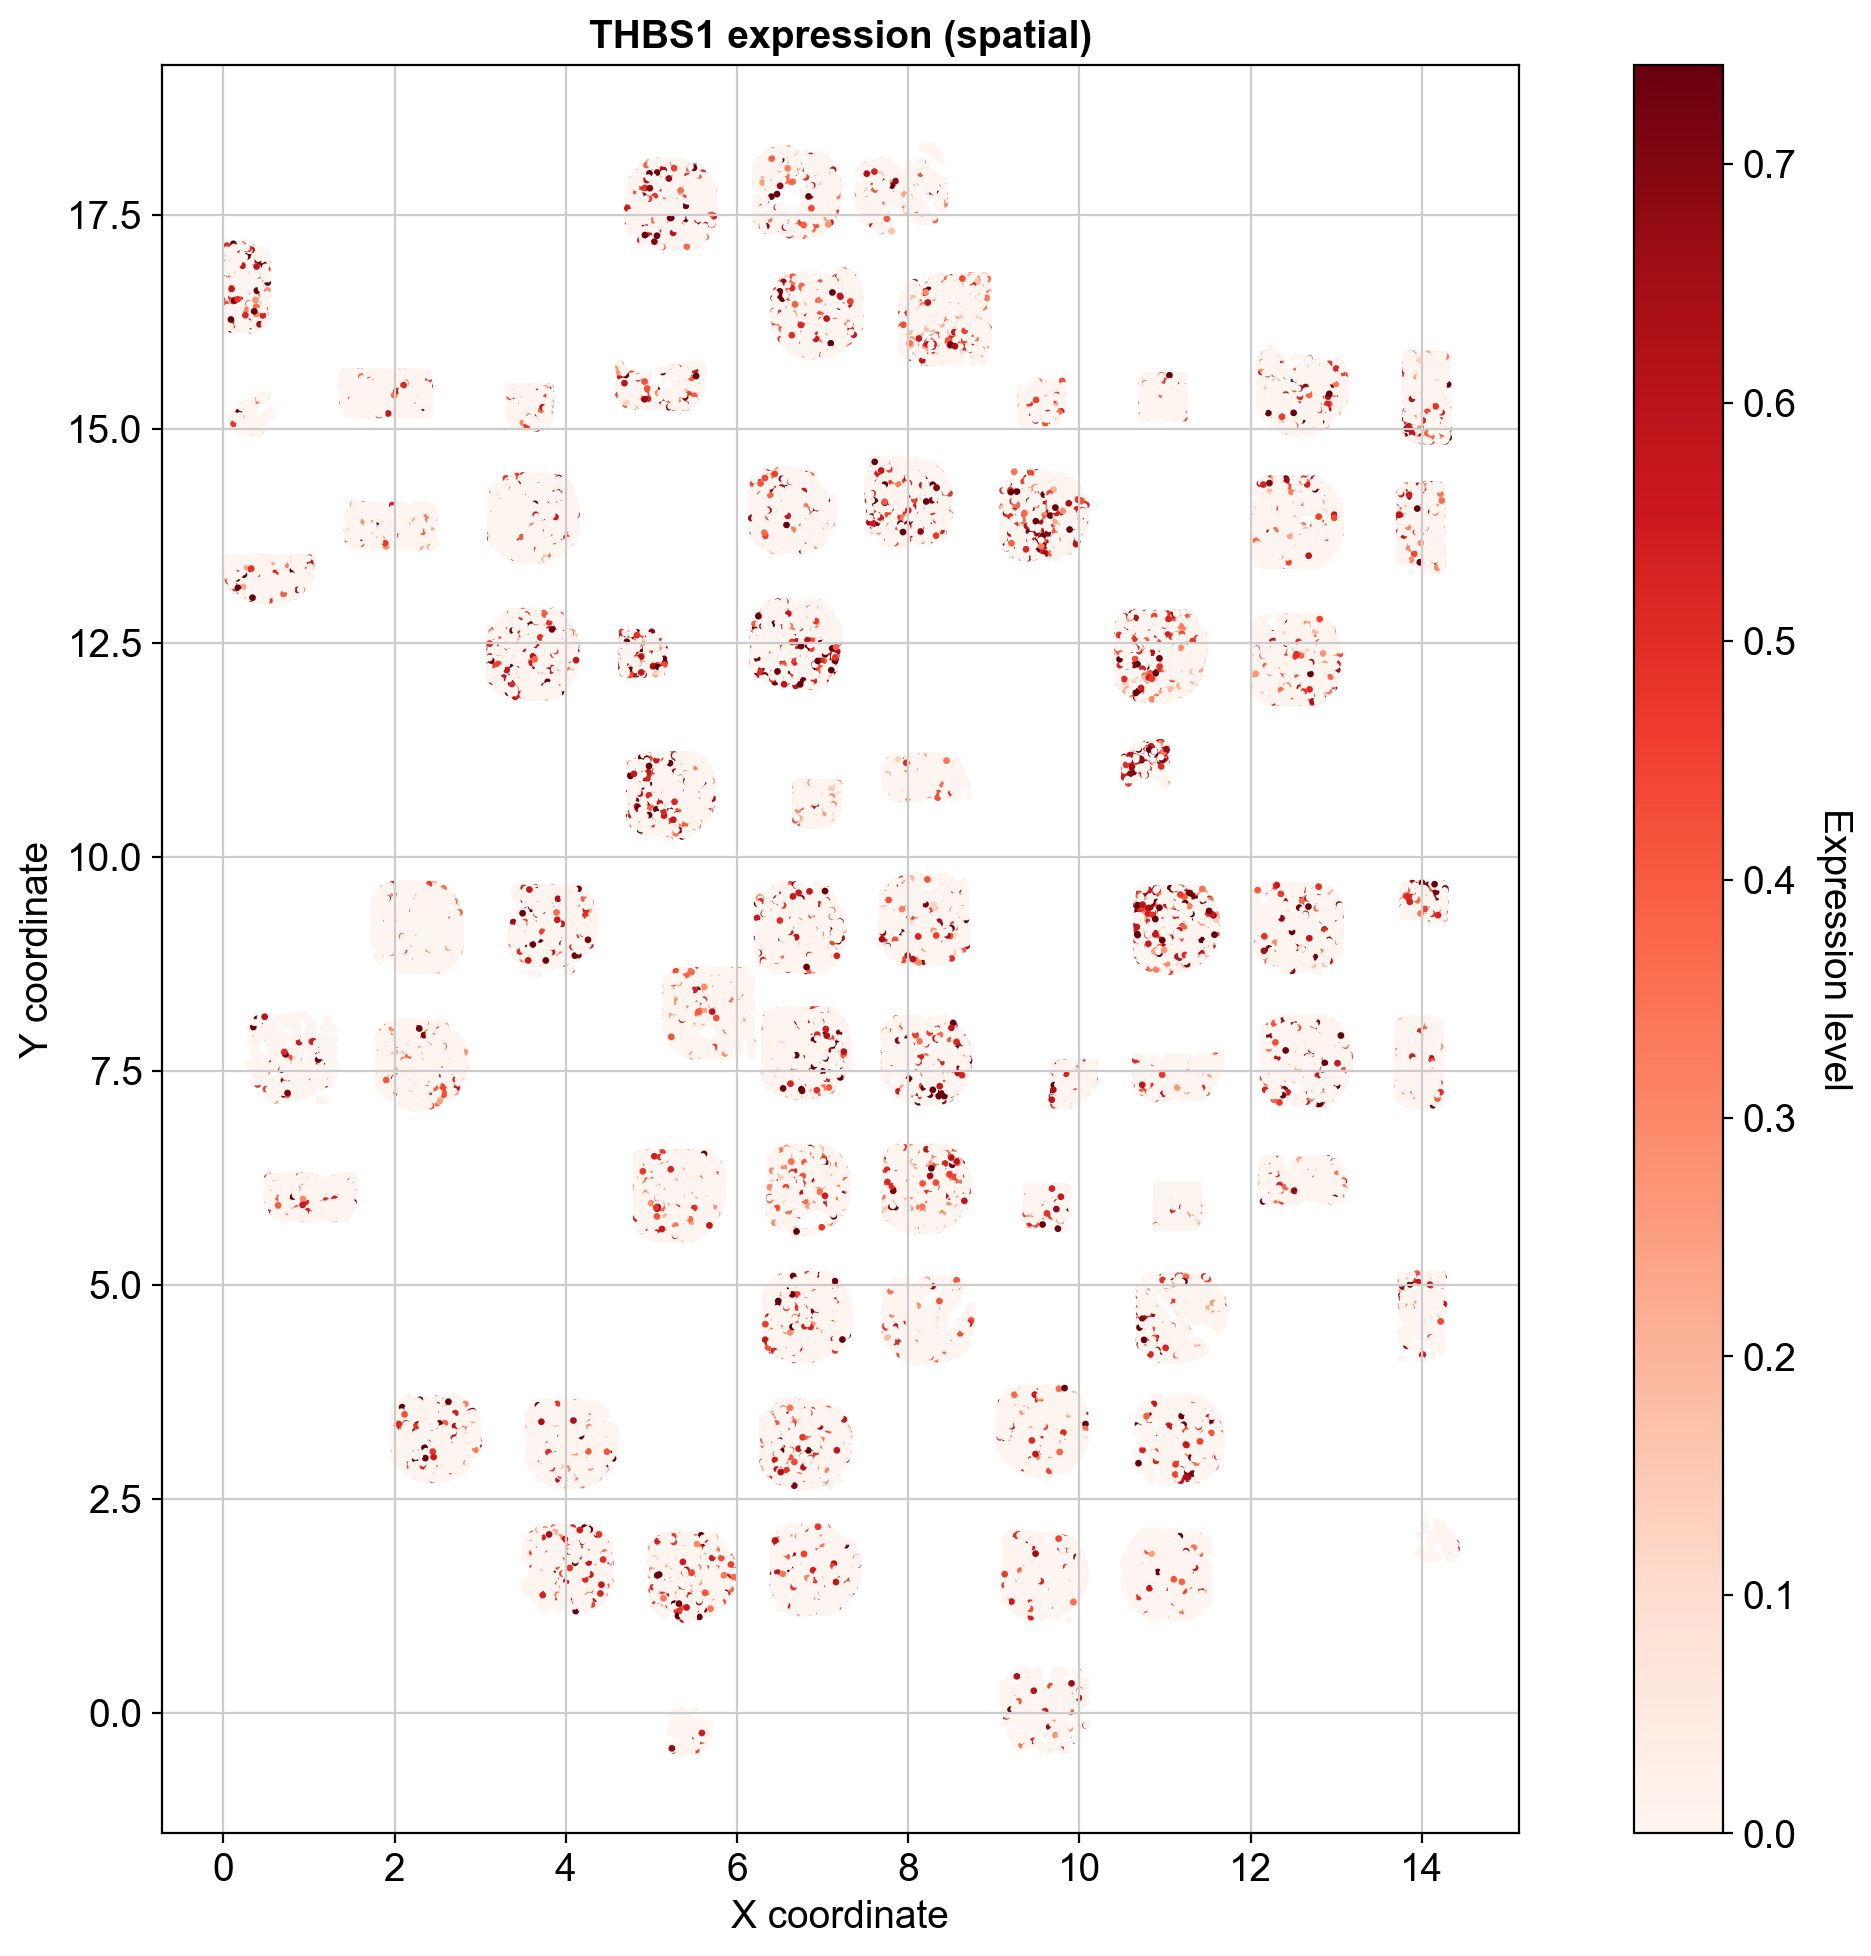

Figure saved: figures/spatial_THBS1_expression.png and .pdf


In [16]:
# Visualize THBS1 expression spatially
if spatial_key and 'THBS1' in adata.var_names:
    # Get THBS1 expression
    thbs1_expr = adata[:, 'THBS1'].X.toarray().flatten() if hasattr(adata.X, 'toarray') else adata[:, 'THBS1'].X.flatten()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    scatter = ax.scatter(adata.obsm[spatial_key][:, 0], 
                        adata.obsm[spatial_key][:, 1],
                        c=thbs1_expr, s=2, cmap='Reds', 
                        vmin=0, vmax=np.percentile(thbs1_expr, 99),
                        rasterized=True)
    
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('THBS1 expression (spatial)', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Expression level', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('figures/spatial_THBS1_expression.png', dpi=300, bbox_inches='tight')
    plt.savefig('figures/spatial_THBS1_expression.pdf', bbox_inches='tight')
    plt.show()
    
    print("Figure saved: figures/spatial_THBS1_expression.png and .pdf")
else:
    print("THBS1 not found in dataset")

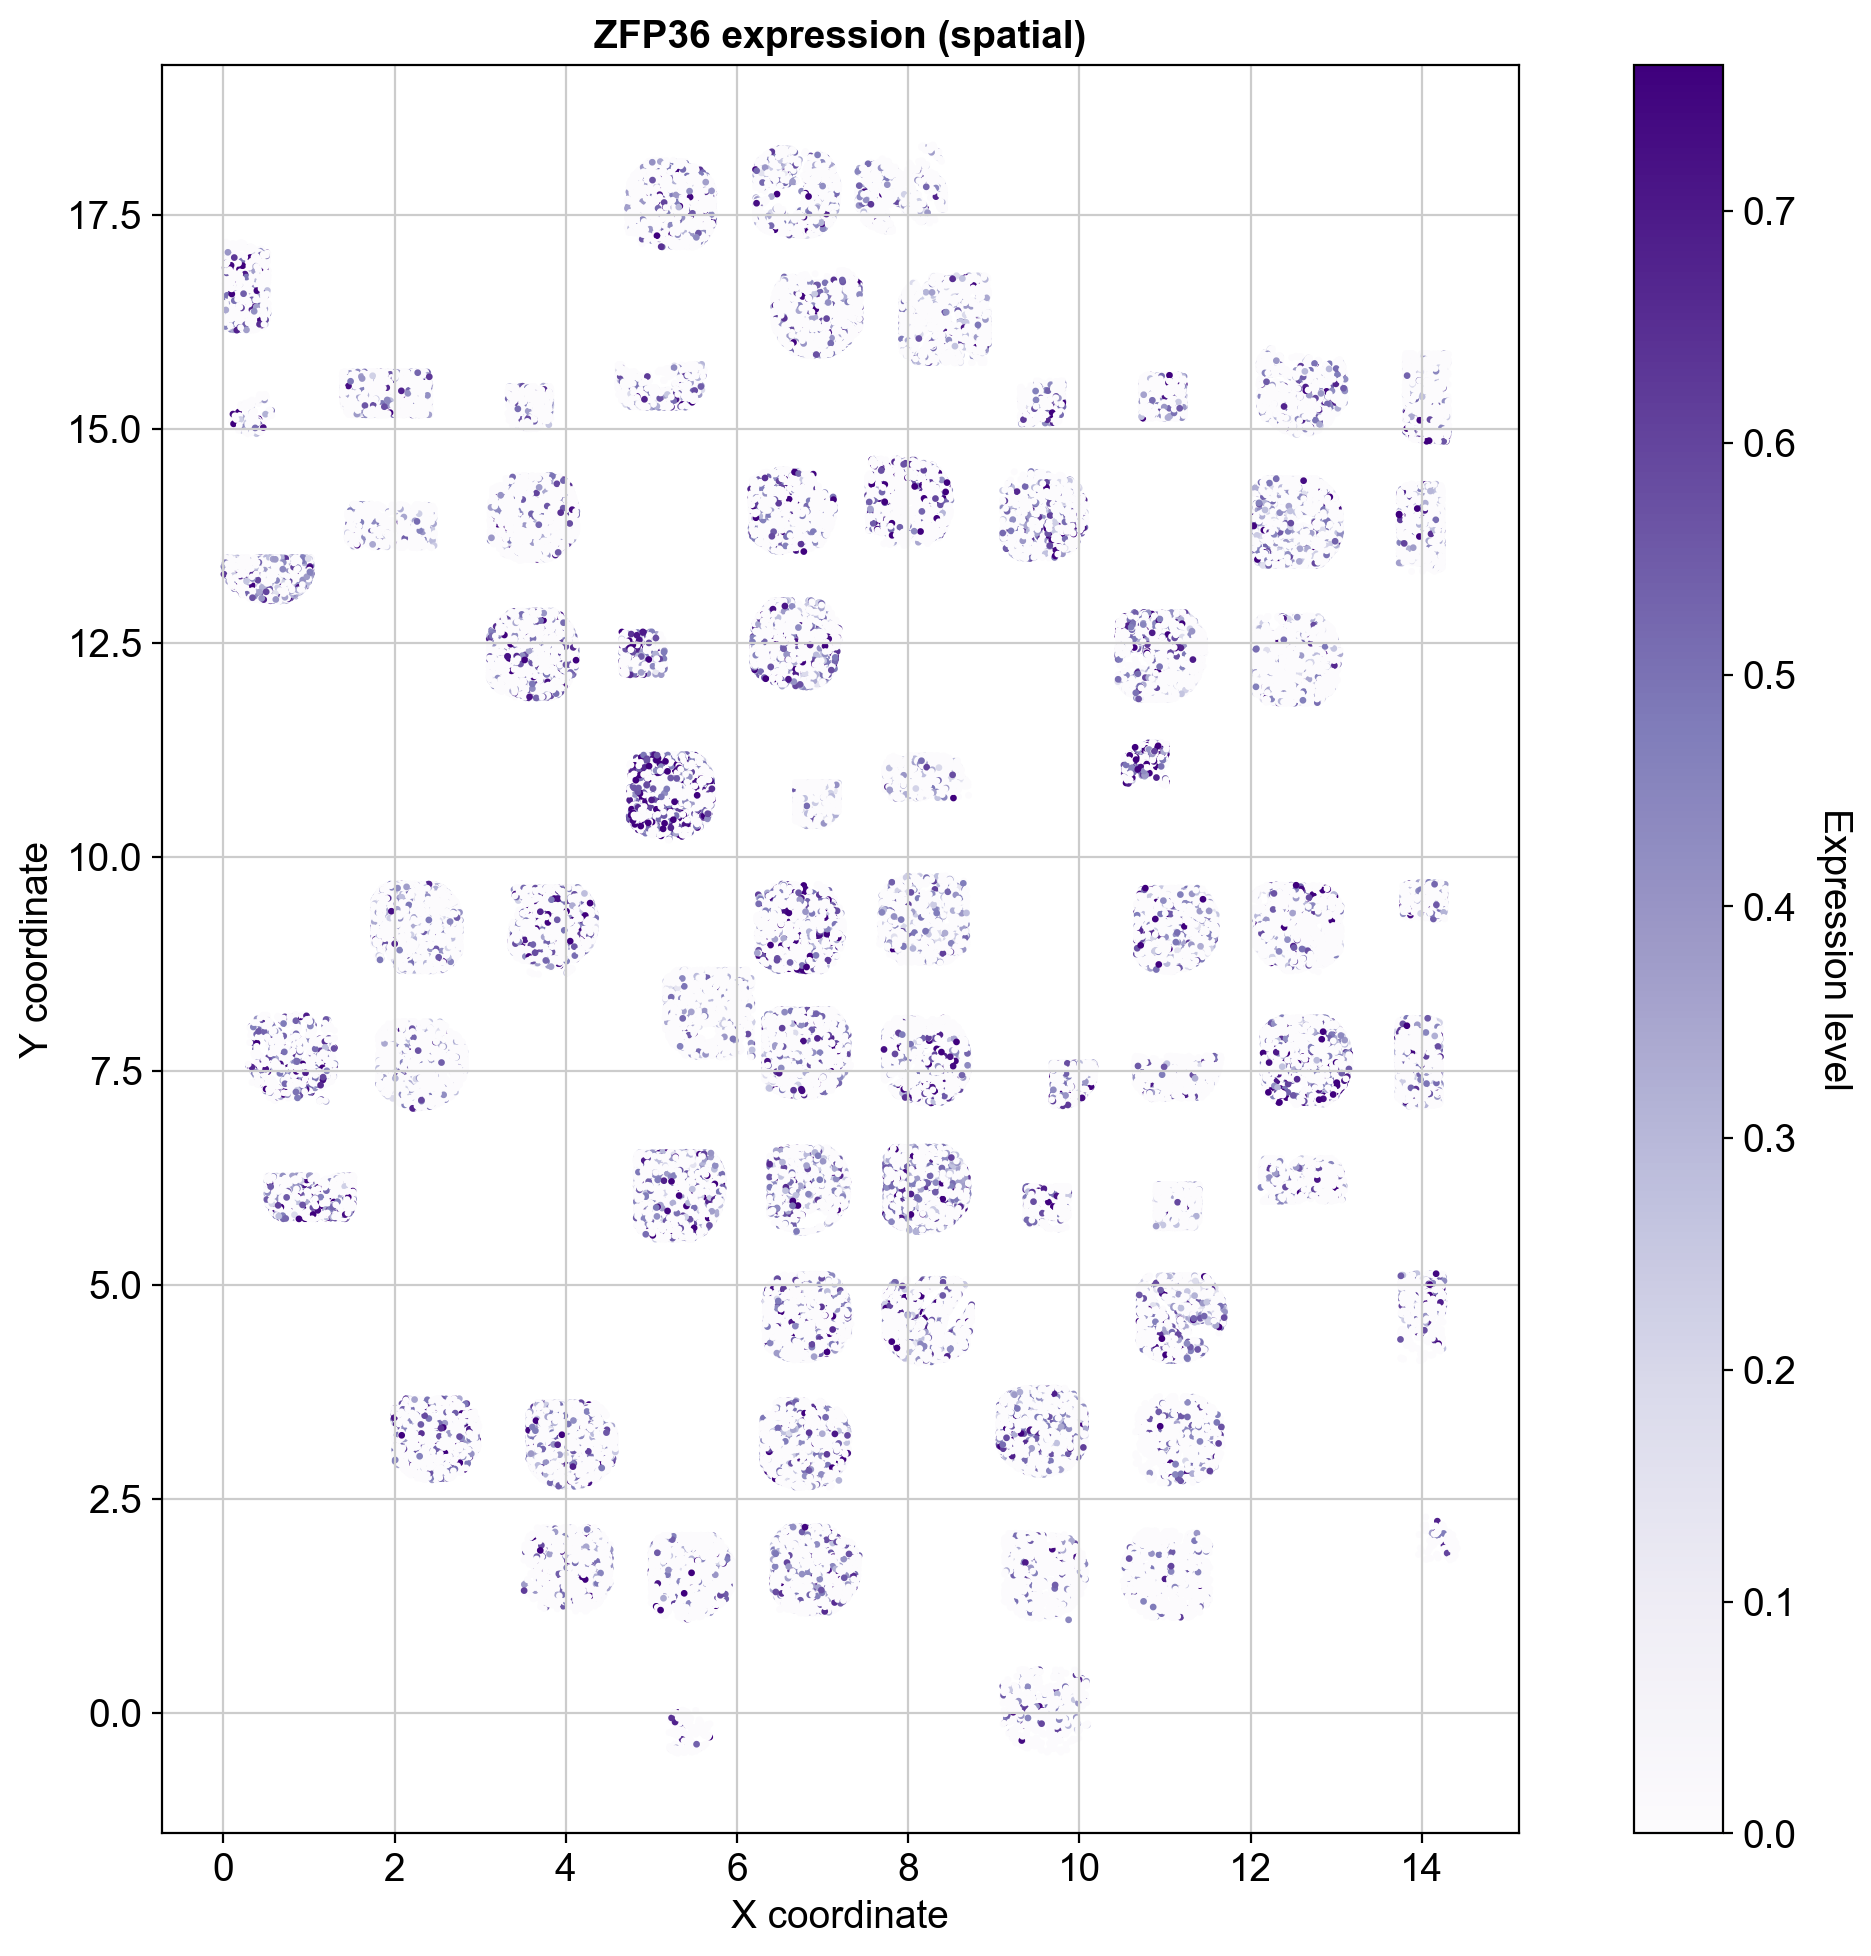

Figure saved: figures/spatial_ZFP36_expression.png and .pdf


In [17]:
# Visualize ZFP36 expression spatially
if spatial_key and 'ZFP36' in adata.var_names:
    # Get ZFP36 expression
    zfp36_expr = adata[:, 'ZFP36'].X.toarray().flatten() if hasattr(adata.X, 'toarray') else adata[:, 'ZFP36'].X.flatten()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    scatter = ax.scatter(adata.obsm[spatial_key][:, 0], 
                        adata.obsm[spatial_key][:, 1],
                        c=zfp36_expr, s=2, cmap='Purples',
                        vmin=0, vmax=np.percentile(zfp36_expr, 99),
                        rasterized=True)
    
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('ZFP36 expression (spatial)', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Expression level', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('figures/spatial_ZFP36_expression.png', dpi=300, bbox_inches='tight')
    plt.savefig('figures/spatial_ZFP36_expression.pdf', bbox_inches='tight')
    plt.show()
    
    print("Figure saved: figures/spatial_ZFP36_expression.png and .pdf")
else:
    print("ZFP36 not found in dataset")

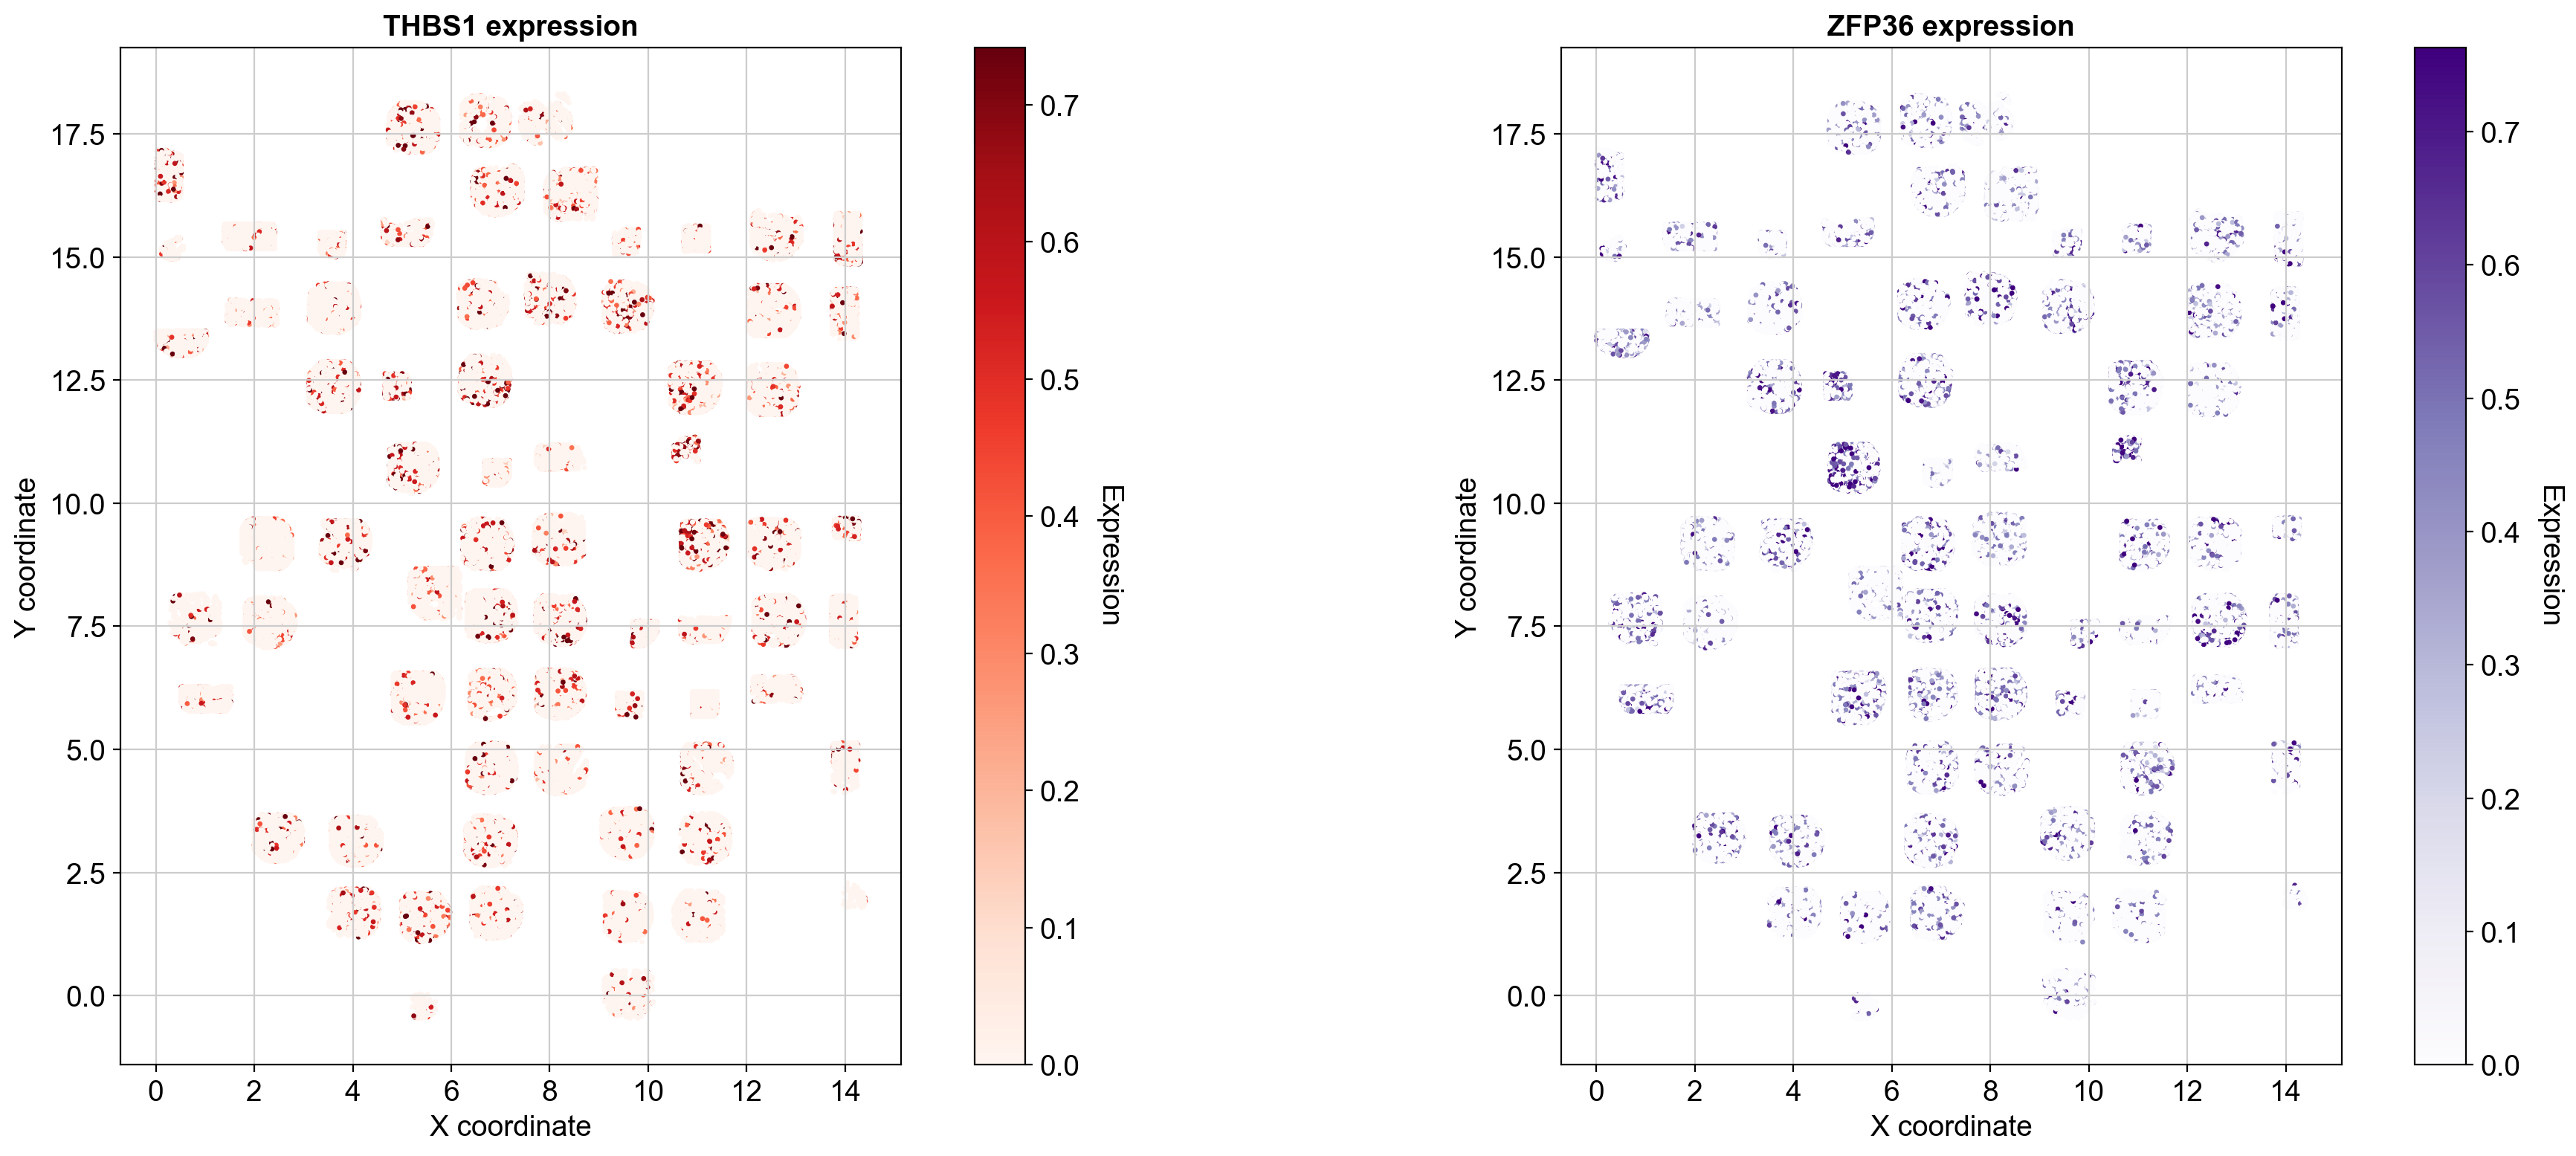

Figure saved: figures/spatial_THBS1_ZFP36_combined.png and .pdf


In [18]:
# Create combined THBS1 and ZFP36 visualization
if spatial_key and 'THBS1' in adata.var_names and 'ZFP36' in adata.var_names:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # THBS1
    thbs1_expr = adata[:, 'THBS1'].X.toarray().flatten() if hasattr(adata.X, 'toarray') else adata[:, 'THBS1'].X.flatten()
    scatter1 = axes[0].scatter(adata.obsm[spatial_key][:, 0], 
                              adata.obsm[spatial_key][:, 1],
                              c=thbs1_expr, s=2, cmap='Reds',
                              vmin=0, vmax=np.percentile(thbs1_expr, 99),
                              rasterized=True)
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Y coordinate')
    axes[0].set_title('THBS1 expression', fontsize=14, fontweight='bold')
    axes[0].set_aspect('equal')
    cbar1 = plt.colorbar(scatter1, ax=axes[0])
    cbar1.set_label('Expression', rotation=270, labelpad=20)
    
    # ZFP36
    zfp36_expr = adata[:, 'ZFP36'].X.toarray().flatten() if hasattr(adata.X, 'toarray') else adata[:, 'ZFP36'].X.flatten()
    scatter2 = axes[1].scatter(adata.obsm[spatial_key][:, 0], 
                              adata.obsm[spatial_key][:, 1],
                              c=zfp36_expr, s=2, cmap='Purples',
                              vmin=0, vmax=np.percentile(zfp36_expr, 99),
                              rasterized=True)
    axes[1].set_xlabel('X coordinate')
    axes[1].set_ylabel('Y coordinate')
    axes[1].set_title('ZFP36 expression', fontsize=14, fontweight='bold')
    axes[1].set_aspect('equal')
    cbar2 = plt.colorbar(scatter2, ax=axes[1])
    cbar2.set_label('Expression', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('figures/spatial_THBS1_ZFP36_combined.png', dpi=300, bbox_inches='tight')
    plt.savefig('figures/spatial_THBS1_ZFP36_combined.pdf', bbox_inches='tight')
    plt.show()
    
    print("Figure saved: figures/spatial_THBS1_ZFP36_combined.png and .pdf")